#Data Cleaning and Preparation

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# Set variables
OUTCOME_VAR = 'inhosp_death_30day'
INPUT_VARS = ['age', 'sex', 'emop', 'bmi', 'andur',
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_albumin', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium']

# Load operations
df = pd.read_csv('operations.csv')

# Find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id','subject_id']].groupby('subject_id')['op_id'].idxmin()]

# Whether the time of in-hospital death ('inhosp_death_time') is less than the time when the patient was
# out of the operating room ('orout_time') plus 30 days (converted to minutes).
df[OUTCOME_VAR] = (df['inhosp_death_time'] < df['orout_time'] + 30 * 24 * 60)

# Filters to include only those rows where the value in the column 'asa' is less than 6. higher asa indicates more serious disease
df = df[(df['asa'] < 6)]

# Duration of anesthesia for each patient
df.loc[:, 'andur'] = df['anend_time'] - df['anstart_time']

# BMI only for rows where valid_mask is True (i.e., where height is greater than 10 cm).
valid_mask = df['height'] > 10
df['bmi'] = np.nan
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

# Load labs
df_lab = pd.read_csv('labs.csv')

# Merge labs & operations
for item_name in ('hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium'):
    df = pd.merge_asof(df.sort_values('orin_time'),
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'),
                    left_on='orin_time', right_on='chart_time', by='subject_id',
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

# Convert gender to a boolean column
df['sex'] = df['sex'] == 'M'

# Load diagnosis data
df_diagnosis = pd.read_csv('diagnosis.csv')

# Merge diagnosis data with operations & medications
df = pd.merge(df, df_diagnosis[['subject_id', 'icd10_cm']], on='subject_id', how='left')

# "icd10_cm" = 1 for patient has breast cancer ("C50"), 0 for any other diagnosis (getting just breast cancer patients)
df['icd10_cm'] = np.where(df['icd10_cm'] == 'C50', 1, 0)
df = df[df["icd10_cm"] == 1]

# Data preview
df.head(10)

,op_id,subject_id,hadm_id,case_id,opdate,age,sex,weight,height,race,asa,emop,department,antype,icd10_pcs,orin_time,orout_time,opstart_time,opend_time,admission_time,discharge_time,anstart_time,anend_time,cpbon_time,cpboff_time,icuin_time,icuout_time,inhosp_death_time,inhosp_death_30day,andur,bmi,preop_hb,preop_platelet,preop_aptt,preop_wbc,preop_ptinr,preop_glucose,preop_bun,preop_albumin,preop_ast,preop_alt,preop_creatinine,preop_sodium,preop_potassium,icd10_cm
19,429493668,196269490,269094492,NaN,0,55,False,60.0,158.0,Asian,2.0,1,NS,General,009T0,10,300,120.0,285.0,0,10075,50.0,290.0,NaN,NaN,290.0,2575.0,NaN,False,240.0,24.034610,11.9,233.0,25.1,13.79,0.95,120.0,16.0,3.9,11.0,13.0,0.58,143.0,3.8,1
20,429493668,196269490,269094492,NaN,0,55,False,60.0,158.0,Asian,2.0,1,NS,General,009T0,10,300,120.0,285.0,0,10075,50.0,290.0,NaN,NaN,290.0,2575.0,NaN,False,240.0,24.034610,11.9,233.0,25.1,13.79,0.95,120.0,16.0,3.9,11.0,13.0,0.58,143.0,3.8,1
28,429493668,196269490,269094492,NaN,0,55,False,60.0,158.0,Asian,2.0,1,NS,General,009T0,10,300,120.0,285.0,0,10075,50.0,290.0,NaN,NaN,290.0,2575.0,NaN,False,240.0,24.034610,11.9,233.0,25.1,13.79,0.95,120.0,16.0,3.9,11.0,13.0,0.58,143.0,3.8,1
30,429493668,196269490,269094492,NaN,0,55,False,60.0,158.0,Asian,2.0,1,NS,General,009T0,10,300,120.0,285.0,0,10075,50.0,290.0,NaN,NaN,290.0,2575.0,NaN,False,240.0,24.034610,11.9,233.0,25.1,13.79,0.95,120.0,16.0,3.9,11.0,13.0,0.58,143.0,3.8,1
33,429493668,196269490,269094492,NaN,0,55,False,60.0,158.0,Asian,2.0,1,NS,General,009T0,10,300,120.0,285.0,0,10075,50.0,290.0,NaN,NaN,290.0,2575.0,NaN,False,240.0,24.034610,11.9,233.0,25.1,13.79,0.95,120.0,16.0,3.9,11.0,13.0,0.58,143.0,3.8,1
36,429493668,196269490,269094492,NaN,0,55,False,60.0,158.0,Asian,2.0,1,NS,General,009T0,10,300,120.0,285.0,0,10075,50.0,290.0,NaN,NaN,290.0,2575.0,NaN,False,240.0,24.034610,11.9,233.0,25.1,13.79,0.95,120.0,16.0,3.9,11.0,13.0,0.58,143.0,3.8,1
38,429493668,196269490,269094492,NaN,0,55,False,60.0,158.0,Asian,2.0,1,NS,General,009T0,10,300,120.0,285.0,0,10075,50.0,290.0,NaN,NaN,290.0,2575.0,NaN,False,240.0,24.034610,11.9,233.0,25.1,13.79,0.95,120.0,16.0,3.9,11.0,13.0,0.58,143.0,3.8,1
39,429493668,196269490,269094492,NaN,0,55,False,60.0,158.0,Asian,2.0,1,NS,General,009T0,10,300,120.0,285.0,0,10075,50.0,290.0,NaN,NaN,290.0,2575.0,NaN,False,240.0,24.034610,11.9,233.0,25.1,13.79,0.95,120.0,16.0,3.9,11.0,13.0,0.58,143.0,3.8,1
41,429493668,196269490,269094492,NaN,0,55,False,60.0,158.0,Asian,2.0,1,NS,General,009T0,10,300,120.0,285.0,0,10075,50.0,290.0,NaN,NaN,290.0,2575.0,NaN,False,240.0,24.034610,11.9,233.0,25.1,13.79,0.95,120.0,16.0,3.9,11.0,13.0,0.58,143.0,3.8,1
5147,487587725,197919274,256733823,NaN,0,75,False,53.0,148.0,Asian,2.0,0,OT,MAC,08DJ3,465,515,485.0,510.0,0,1435,480.0,510.0,NaN,NaN,NaN,NaN,NaN,False,30.0,24.196494,13.2,291.0,27.2,5.94,0.88,120.0,24.0,4.0,23.0,22.0,0.68,143.0,4.5,1


# Modeling

111/107074 (0.10%) train, 47/45889 (0.10%) test, 18 features
ASA auroc: 0.530, auprc: 0.001
LR auroc: 0.978, auprc: 0.958
 
 
age: 0.24316276310475213
sex: 4.384701151458627e-06
emop: 0.55532955346791
bmi: 0.44753419781070447
andur: 0.010072482772850043
preop_hb: 0.08461666788511871
preop_platelet: 0.07625613246003955
preop_wbc: 0.13888752994329942
preop_aptt: 0.05191293357606626
preop_ptinr: 0.5132103331004727
preop_glucose: 0.0675176571290851
preop_bun: 0.18478094959819752
preop_albumin: 0.8468154487944275
preop_ast: 0.1016946787867004
preop_alt: 0.04222706697358694
preop_creatinine: 1.0370470169993289
preop_sodium: 1.1079040392454587
preop_potassium: 0.4883047184664658




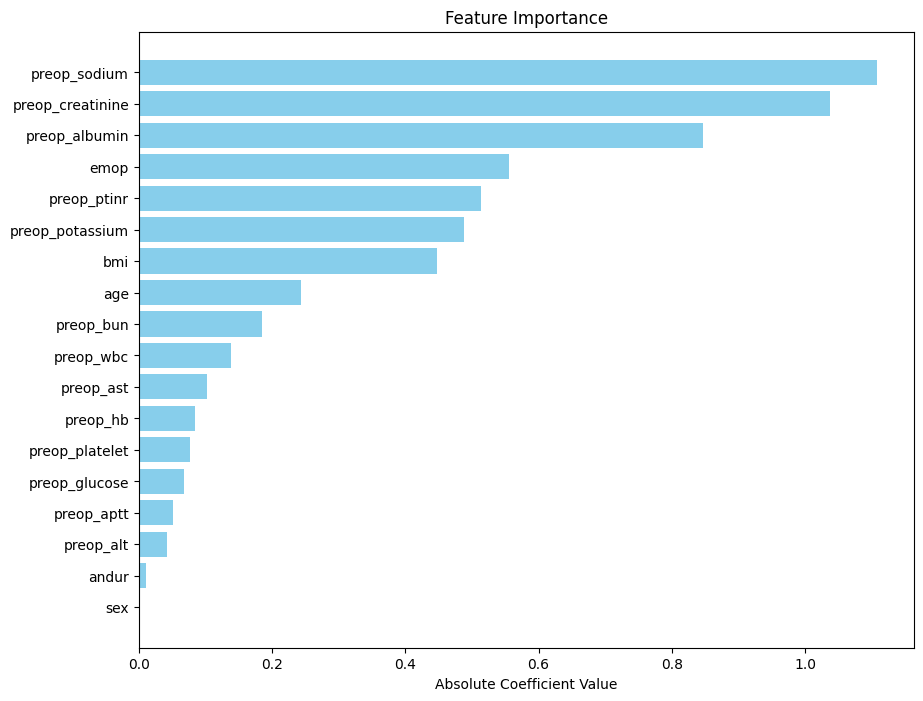

In [10]:
# Split a dataset into train and test sets
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
ntrain = int(len(df) * 0.7)

from sklearn.model_selection import train_test_split

# Stratified split
x_train, x_test, y_train, y_test = train_test_split(
    df[INPUT_VARS], df[OUTCOME_VAR], test_size=0.3, stratify=df[OUTCOME_VAR], random_state=1
)


# Print the number of train and test sets
print(f'{sum(y_train)}/{len(y_train)} ({np.mean(y_train)*100:.2f}%) train, {sum(y_test)}/{len(y_test)} ({np.mean(y_test)*100:.2f}%) test, {x_train.shape[1]} features', flush=True)

# ASA class
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
y_pred_asa = df.loc[ntrain:, 'asa']

# Compute area under the ROC AUC from prediction scores
auroc_asa = roc_auc_score(y_test, y_pred_asa)

# Compute the precision recall curve
prc_asa, rec_asa, thresholds = precision_recall_curve(y_test, y_pred_asa)

# Compute area under the precision-recall curve
auprc_asa = auc(rec_asa, prc_asa)
print('ASA auroc: {:.3f}, auprc: {:.3f}'.format(auroc_asa, auprc_asa), flush=True)

# Logistic regression using SimpleImputer()
from sklearn.impute import SimpleImputer
imp = SimpleImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# Logistic regression using LogisticRegression()
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=5000).fit(x_train_imputed, y_train)
y_pred_lr = model.predict_proba(x_test_imputed)[:, 1]

# compute AUROC and AUPRC
auroc_lr = roc_auc_score(y_test, y_pred_lr)
prc_lr, rec_lr, thresholds = precision_recall_curve(y_test, y_pred_lr)
auprc_lr = auc(rec_lr, prc_lr)
print('LR auroc: {:.3f}, auprc: {:.3f}'.format(auroc_lr, auprc_lr), flush=True)
print(" \n ")

# Compute feature importance
feature_names = x_train.columns
for feature_name, coef in zip(feature_names, model.coef_[0]):
  print(f"{feature_name}: {abs(coef)}")

fpr_asa, tpr_asa, _ = roc_curve(y_test, y_pred_asa)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

feature_names = x_train.columns
coefficients = model.coef_[0]

# Create a list of (feature_name, absolute_coefficient) tuples and sort them by the coefficient value
features_coefficients = sorted(zip(feature_names, abs(coefficients)), key=lambda x: x[1], reverse=True)

# Unzip the feature names and their corresponding coefficients into separate lists
sorted_features, sorted_coefficients = zip(*features_coefficients)

# Plot feature imoprtance
print("\n")
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # invert the y-axis to have the most important feature on top
plt.show()

#Cross Validation

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Define the number of splits for cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# Create a pipeline that first imputes missing values then fits a logistic model
pipeline = make_pipeline(SimpleImputer(), LogisticRegression(max_iter=5000))

# Define the metrics to evaluate the model
scoring = ['roc_auc', 'average_precision']

# Perform cross-validation
results = cross_validate(pipeline, df[INPUT_VARS], df[OUTCOME_VAR], cv=kf, scoring=scoring, return_train_score=False)

# Print the average results from cross-validation
print(f"Average ROC AUC: {results['test_roc_auc'].mean():.3f}")
print(f"Average Precision-Recall AUC: {results['test_average_precision'].mean():.3f}")


Average ROC AUC: 0.987
Average Precision-Recall AUC: 0.975


#Plot

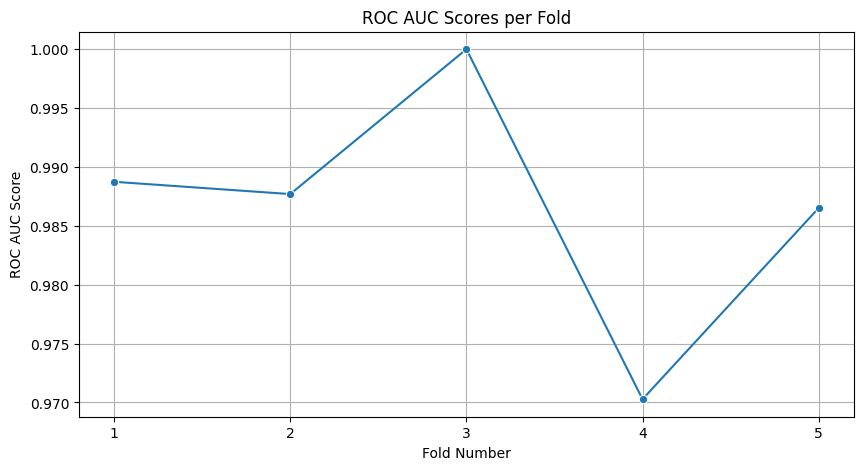

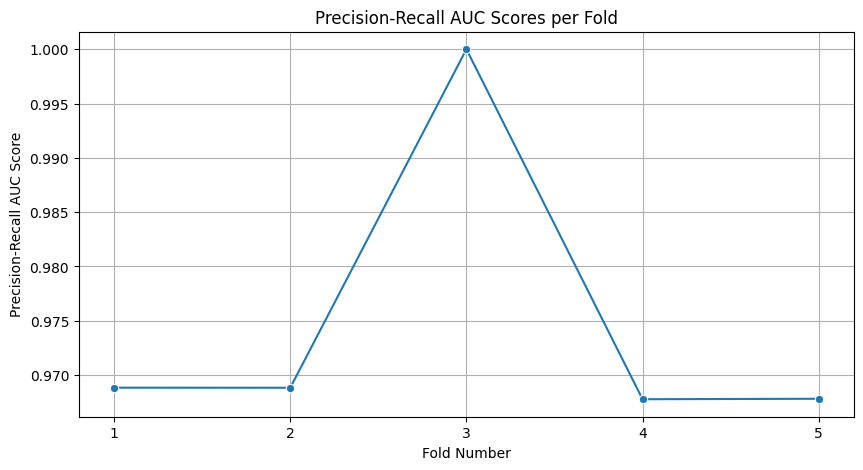

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ROC AUC scores across folds
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, n_splits + 1), y=results['test_roc_auc'], marker='o')
plt.title('ROC AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('ROC AUC Score')
plt.xticks(range(1, n_splits + 1))
plt.grid(True)
plt.show()

# Plotting Precision-Recall AUC scores across folds
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, n_splits + 1), y=results['test_average_precision'], marker='o')
plt.title('Precision-Recall AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Precision-Recall AUC Score')
plt.xticks(range(1, n_splits + 1))
plt.grid(True)
plt.show()
